In [16]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import matplotlib.pyplot as plt

In [17]:
import json
from numpy import random
import random
import numpy as np

with open("ps_at_q_6_325.json", 'r') as fid:
    loaded_dict = json.load(fid)
line = xt.Line.from_dict(loaded_dict)
# line.particle_ref = xp.Particles(
#     p0c = 1.399856671256738,
#     q = 54./208.,
#     m0 = 0.931494*(207.947/208.),
# )

Done loading line from dict.           


In [ ]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356
PS_radius = 70.079

In [18]:
from signal_gen import generate_chirp_signal

EXCITER_SAMPLING_FREQ = 1e6
FREV = 470151.0308

CHIRP_START = FREV * .3
CHIRP_STOP = FREV * .35

exciter_time, exciter_signal, turns = generate_chirp_signal(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START,
    chirp_stop_freq = CHIRP_STOP
)

In [19]:
ctx = xo.ContextCpu()

N_PART = int( 5e2 )
N_TURN = int( 5e2 )

exciter = xt.Exciter(
    _context = ctx,
    samples = exciter_signal,
    sampling = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [0.001]
)

smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)

smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)

In [20]:
line.insert_element(
    element = exciter,
    name = 'EXCITER',
    index = 'pr.kfb97'
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

In [21]:
from pybt.tools.particles import beam_distrib_norm as bdn
from pybt.tools.particles import dpp_distrib_norm as ddn

EMIT = 5e-6
parts_x = bdn(
    alpha = 0.4244839305372821,
    beta = 26.875635235760765,
    eps = EMIT,
    nparts = N_PART,
    nsigma = 5
)
parts_y = bdn(
    alpha = -0.07355720828438532,
    beta = 9.64757288019518,
    eps = EMIT,
    nparts = N_PART,
    nsigma = 5
)
parts_s = ddn(
    dpp = 1e-3,
    nparts = N_PART,
    nsigma = 2
)

parts_x_disp =  np.array(parts_x[:,0]) + np.array(4.043911519775766 * parts_s)
parts_px_disp = np.array(parts_x[:,1]) + np.array(-0.03630510415370579 * parts_s)

parts_y_disp =  np.array(parts_y[:,0]) + np.array(7.824523014183614e-13 * parts_s)
parts_py_disp = np.array(parts_y[:,1]) + np.array(-5.067241948016229e-14 * parts_s)

In [22]:
tracker = line.build_tracker()
parts = tracker.build_particles(
    x =  parts_x_disp,
    px = parts_px_disp,
    y =  parts_y_disp,
    py = parts_py_disp
)

generating ./97840ea39db047f7a658052d528083d6.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


AssertionError: `particle_ref` or `particle_on_co` must be provided!

In [ ]:
tracker.track(
    particles = parts, 
    num_turns = N_TURN
)

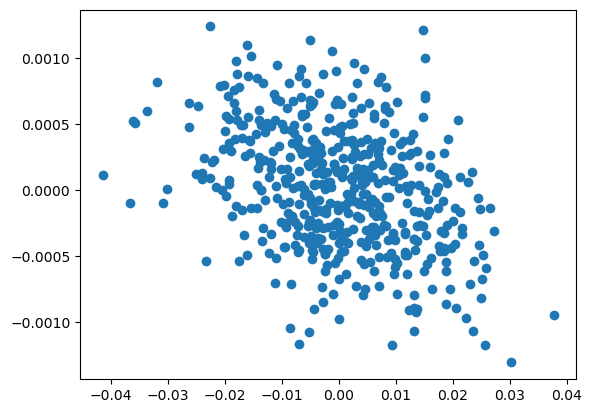

In [ ]:
fig, ax = plt.subplots()
ax.scatter(parts_x_disp, parts_px_disp)

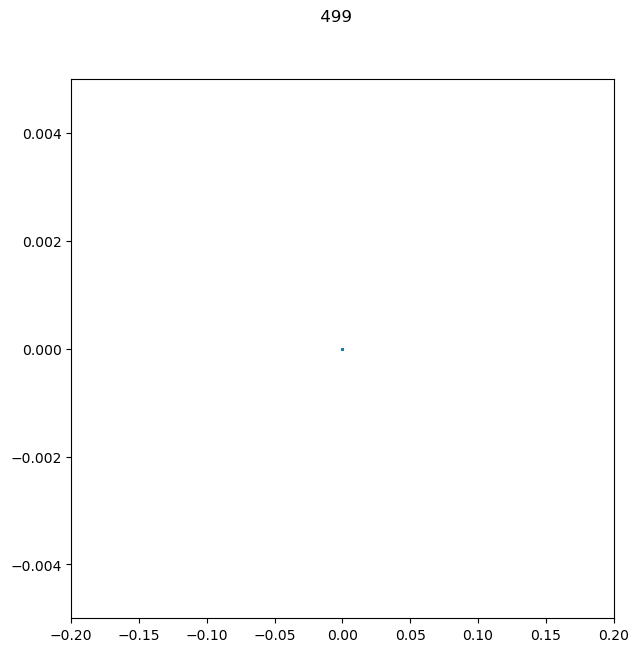

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.005, 0.005)
    fig.suptitle(f"{i:>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("rfko.gif", writer=PillowWriter(fps=30))


In [ ]:
tw = tracker.twiss(method='4d')
tw['qx']

6.325186740243226

NameError: name 'tw' is not defined

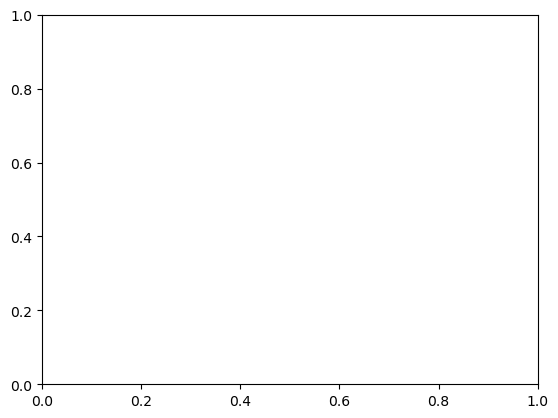

In [ ]:
fig, ax = plt.subplots()
ax.plot(tw['s'], tw['x'])